In [68]:
from __future__ import print_function
import numpy as np
import pandas as pd


from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression as logreg

import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma

from sklearn.feature_selection import chi2

import scipy as sp
from scipy import stats

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [69]:
# the directory that contains all the files
dataDirectory = 'data/'

In [70]:
file = 'llcp2017_formatted.csv'
df = pd.read_csv(dataDirectory+file)

In [71]:
df.head()

,STATE FIPS CODE,FILE MONTH,INTERVIEW DATE,INTERVIEW MONTH,INTERVIEW DAY,INTERVIEW YEAR,FINAL DISPOSITION,ANNUAL SEQUENCE NUMBER,PRIMARY SAMPLING UNIT,CORRECT TELEPHONE NUMBER?,...,_IMPCAGE,_IMPCRAC,_IMPCSEX,_IMPEDUC,_IMPHOME,_IMPMRTL,_IMPNPH,_IMPSEX,_M_RACE,_URBNRRL
0,Alabama,January,1302017,01,30,2017,1100,2017000001,2017000001,Yes,...,Not asked or Missing,Missing,Missing,Missing,Missing,Missing,NaN,Not asked or Missing,Not asked or Missing,Missing
1,Alabama,January,1122017,01,12,2017,1100,2017000002,2017000002,Yes,...,Not asked or Missing,Missing,Missing,Missing,Missing,Missing,NaN,Not asked or Missing,Not asked or Missing,Missing
2,Alabama,January,1102017,01,10,2017,1100,2017000003,2017000003,Yes,...,Not asked or Missing,Missing,Missing,Missing,Missing,Missing,NaN,Not asked or Missing,Not asked or Missing,Missing
3,Alabama,January,2082017,02,8,2017,1200,2017000004,2017000004,Yes,...,Not asked or Missing,Missing,Missing,Missing,Missing,Missing,NaN,Not asked or Missing,Not asked or Missing,Missing
4,Alabama,January,1302017,01,30,2017,1100,2017000005,2017000005,Yes,...,Not asked or Missing,Missing,Missing,Missing,Missing,Missing,NaN,Not asked or Missing,Not asked or Missing,Missing


In [72]:
print("Number of records: ",len(df))

Number of records:  450642


### Helper Functions

In [73]:
def containsKeyword(sent):
    sent = sent.lower()
    for f in filterList:
        if f in sent:
            return True
    return False

## Label Computing

In [74]:
df.rename(columns={'CURRENT E-CIGARETTE USER CALCULATED VARI': 'esmoke', \
                     'CURRENT SMOKING CALCULATED VARIABLE':'smoke'},inplace = True)


mapper = {'Current E-cigarette user': 'Yes', 'Not currently using E-cigarettes': 'No' }
df['esmoke'] = df['esmoke'].map(mapper)

print("data size: ",len(df))
df = df[df.smoke.apply(lambda x: x in ['Yes','No']) ]
df = df[df.esmoke.apply(lambda x: x in ['Yes','No']) ]
print("clean data size: ",len(df))

print("Frequency distributions:")
print(df.esmoke.value_counts())
print(df.smoke.value_counts())


data size:  450642
clean data size:  427526
Frequency distributions:
No     413906
Yes     13620
Name: esmoke, dtype: int64
No     364794
Yes     62732
Name: smoke, dtype: int64


In [8]:
# remove non smokers
df = df[ (df.smoke == 'Yes') | (df.esmoke == 'Yes') ]
print("clean data size: ",len(df))

# remove both smokers
df = df[ ~((df.smoke == 'Yes') & (df.esmoke == 'Yes')) ]
print("clean data size: ",len(df))

clean data size:  69143
clean data size:  61934


In [9]:
# label is 1 for esmoker and zero for non smoker
#df['label'] = (df.esmoke == 'Yes') 

In [75]:
df['label'] = df.smoke

## Feature Engineering

In [76]:
# Find the columns that contain smoking key word
filterList = ['smok','cig']    
smokecols = [c for c in df.columns if containsKeyword(c)]
smokecols

## Explore the calculated and computed columns
filterList = ['computed', 'calculated'] + ['label']
calcols = [c for c in df.columns if containsKeyword(c)]
print("Number of calculated/computed columns: ",len(calcols))

# create a datframe that only has calculated columns
comDF = df[calcols]

Number of calculated/computed columns:  40


Column : label
Empty DataFrame
Columns: [esmoke, smoke]
Index: []


ValueError: min() arg is an empty sequence

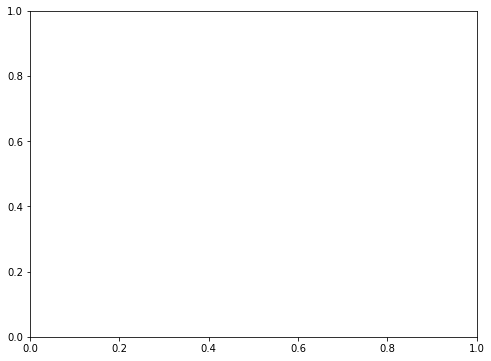

In [77]:
i=39
col = calcols[i]
print("Column :",calcols[i])
s1 = comDF[comDF['label']==True][col].value_counts() 
s1 = s1 *100 / len(comDF[comDF['label']==True])
#s1 = s1.astype(int)
s2 = comDF[comDF['label']==False][col].value_counts() 
s2 = s2 *100 / len(comDF[comDF['label']==False])
#s2 = s2.astype(int)

vcountDF = pd.concat([s1, s2], axis=1)
vcountDF.columns = ['esmoke','smoke']
print(vcountDF)

fig, ax = plt.subplots(figsize=(8,6))
_=sns.barplot(vcountDF.index, vcountDF.esmoke-vcountDF.smoke,ax=ax).set_xticklabels(vcountDF.index,rotation=30)
#sns.barplot(vcountDF.index, vcountDF.smoke,ax=ax)

In [78]:
comDF['ads18_frequentHealthIssue'] = (comDF['COMPUTED PHYSICAL HEALTH STATUS']=='14+ days when physical health not good')
comDF['ads18_frequentHealthIssue'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    369193
True      58333
Name: ads18_frequentHealthIssue, dtype: int64

In [79]:
comDF['ads18_highBP'] = (comDF['HIGH BLOOD PRESSURE CALCULATED VARIABLE']=='Yes')
comDF['ads18_highBP'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    254757
True     172769
Name: ads18_highBP, dtype: int64

In [80]:
comDF['ads18_highChl'] = (comDF['HIGH CHOLESTEROL CALCULATED VARIABLE']=='Yes')
comDF['ads18_highChl'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    277489
True     150037
Name: ads18_highChl, dtype: int64

In [81]:
comDF['ads18_unknownChl'] = (comDF['HIGH CHOLESTEROL CALCULATED VARIABLE']=='Missing')
comDF['ads18_unknownChl'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    379184
True      48342
Name: ads18_unknownChl, dtype: int64

In [82]:
comDF['ads18_asthma'] = (comDF['LIFETIME ASTHMA CALCULATED VARIABLE']=='Yes')
comDF['ads18_asthma'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    367804
True      59722
Name: ads18_asthma, dtype: int64

In [83]:
comDF['ads18_formerasthma'] = (comDF['COMPUTED ASTHMA STATUS']=='Former')
comDF['ads18_formerasthma'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    409873
True      17653
Name: ads18_formerasthma, dtype: int64

In [84]:
comDF['ads18_white'] = (comDF['COMPUTED NON-HISPANIC WHITES/ALL OTHERS']=='Non-Hispanic White')
comDF['ads18_white'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


True     322448
False    105078
Name: ads18_white, dtype: int64

In [85]:
comDF['ads18_weight'] = comDF['COMPUTED WEIGHT IN KILOGRAMS']

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
comDF['ads18_obese'] = (comDF['COMPUTED BODY MASS INDEX CATEGORIES']=='Overweight') | (comDF['COMPUTED BODY MASS INDEX CATEGORIES']=='Obese') 
comDF['ads18_obese'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


True     269399
False    158127
Name: ads18_obese, dtype: int64

In [87]:
comDF['ads18_havechild'] = (comDF['COMPUTED NUMBER OF CHILDREN IN HOUSEHOLD']!='No children in household') 
comDF['ads18_havechild'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    315122
True     112404
Name: ads18_havechild, dtype: int64

In [88]:
edumapper = {'Did not graduate High School':1,
             'Don�t know/Not sure/Missing': 1,
             'Graduated High School': 2,
             'Attended College or Technical School':3,
             'Graduated from College or Technical School':4
            }

comDF['ads18_edu'] = comDF['COMPUTED LEVEL OF EDUCATION COMPLETED CA'].map(edumapper)
comDF['ads18_edu'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


4    161542
3    118762
2    115421
1     31801
Name: ads18_edu, dtype: int64

In [89]:
edumapper = {'Less than $15,000':1,
             'Don�t know/Not sure/Missing': 1,
             '$15,000 to less than $25,000': 2,
             '$25,000 to less than $35,000':3,
             '$35,000 to less than $50,000':4,
             '$50,000 or more':5
            }

comDF['ads18_income'] = comDF['COMPUTED INCOME CATEGORIES'].map(edumapper)
comDF['ads18_income'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


5    177182
1    101492
2     59227
4     51401
3     38224
Name: ads18_income, dtype: int64

In [90]:
comDF['ads18_drinkdaily'] = (comDF['COMPUTED DRINK-OCCASIONS-PER-DAY']=='Drink-Occasions per day') 
comDF['ads18_drinkdaily'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


True     220090
False    207436
Name: ads18_drinkdaily, dtype: int64

In [91]:
comDF['ads18_drinkbinge'] = (comDF['BINGE DRINKING CALCULATED VARIABLE']=='Yes') 
comDF['ads18_drinkbinge'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


False    371730
True      55796
Name: ads18_drinkbinge, dtype: int64

In [92]:
comDF['ads18_fruitIntake'] = comDF['COMPUTED FRUIT INTAKE IN TIMES PER DAY']
#comDF['ads18_fruitIntake'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
comDF['ads18_vegIntake'] = comDF['COMPUTED DARK GREEN VEGETABLE INTAKE IN']

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
comDF['ads18_potatoIntake'] = comDF['COMPUTED POTATO SERVINGS PER DAY']

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
comDF['ads18_exercise'] = (comDF['150 MINUTE PHYSICAL ACTIVITY CALCULATED']!='0 minutes (or vigorous equivalent minutes) of physical activity') 
comDF['ads18_exercise'].value_counts()


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


True     307893
False    119633
Name: ads18_exercise, dtype: int64

In [96]:
comDF['ads18_hivtest'] = (comDF['EVER BEEN TESTED FOR HIV CALCULATED VARI']!='Yes') 
comDF['ads18_hivtest'].value_counts()

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


True     301186
False    126340
Name: ads18_hivtest, dtype: int64

In [97]:
adscols = [c for c in comDF.columns if 'ads18' in c]
len(adscols)

19

In [98]:
engineeredData = comDF[adscols]
print(len(engineeredData))
engineeredData.to_csv('engineeredDataSmoke.csv')

427526


In [32]:
engineeredData = pd.read_csv('engineeredData.csv')
engineeredData.shape

(61934, 20)

### Looking for other variables

In [99]:
filterList = ['age', 'gender', 'male', 'female','sex','height'] + ['label']
othercols = sorted([c for c in df.columns])
othercols

['(EVER TOLD) YOU HAD ANY OTHER TYPES OF C',
 '(EVER TOLD) YOU HAD SKIN CANCER?',
 '(EVER TOLD) YOU HAVE (COPD) CHRONIC OBST',
 '(EVER TOLD) YOU HAVE DIABETES',
 '(EVER TOLD) YOU HAVE KIDNEY DISEASE?',
 '150 MINUTE PHYSICAL ACTIVITY CALCULATED',
 '300 MINUTE PHYSICAL ACTIVITY 2-LEVEL CAL',
 '300 MINUTE PHYSICAL ACTIVITY CALCULATED',
 'ACTIVITIES LIMITED DUE TO ASTHMA DURING',
 'ACTIVITY MET VALUE FOR FIRST ACTIVITY',
 'ACTIVITY MET VALUE FOR SECOND ACTIVITY',
 'ADLTCHLD',
 'ADULT FLU SHOT/SPRAY PAST 12 MOS',
 'ADULTS WITH GOOD OR BETTER HEALTH',
 'AEROBIC AND STRENGTHENING (2-LEVEL)',
 'AEROBIC AND STRENGTHENING GUIDELINE',
 'AGE',
 'AGE AT ASTHMA DIAGNOSIS',
 'AGE TOLD HAD CANCER',
 'AGE WHEN TOLD DIABETIC',
 'ALWAYS OR NEARLY ALWAYS WEAR SEAT BELTS',
 'ALWAYS WEAR SEAT BELTS',
 'ANNUAL SEQUENCE NUMBER',
 'ANY FIREARMS IN HOME',
 'ANY FIREARMS LOADED',
 'ANY LOADED FIREARMS ALSO UNLOCKED',
 'ARE YOU 18 YEARS OF AGE OR OLDER?',
 'ARE YOU 18 YEARS OF AGE OR OLDER?.1',
 'ARE YOU A VETERA

In [14]:
df['STATE FIPS CODE'].value_counts()

Florida                 3647
Kansas                  3083
Indiana                 2187
Minnesota               2181
Ohio                    1998
Nebraska                1981
Arizona                 1948
Kentucky                1672
Michigan                1617
South Carolina          1592
New York                1525
Washington              1509
Texas                   1432
Maryland                1423
New Jersey              1390
Maine                   1300
Missouri                1283
Virginia                1264
South Dakota            1168
West Virginia           1134
Tennessee               1123
Colorado                1115
Iowa                    1101
Alabama                 1076
Connecticut             1053
Pennsylvania            1042
North Dakota            1034
Oklahoma                 975
California               968
Montana                  956
New Mexico               948
Hawaii                   939
Utah                     897
Louisiana                889
Georgia       

Column : STATE FIPS CODE


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


                        esmoke     smoke
Alabama               1.372641  1.779443
Alaska                0.405553  0.878915
Arizona               4.227110  3.020370
Arkansas              0.967088  1.291357
California            2.417720  1.464258
Colorado              2.651692  1.701997
Connecticut           1.809390  1.687589
Delaware              0.904695  0.907732
District of Columbia  0.545937  1.102246
Florida               6.379660  5.831817
Georgia               1.450632  1.347189
Guam                  0.639526  0.520505
Hawaii                2.464514  1.406624
Idaho                 0.951490  0.880716
Illinois              1.169864  1.080633
Indiana               3.197629  3.569692
Iowa                  1.653408  1.792050
Kansas                5.085010  4.965510
Kentucky              2.230541  2.753814
Louisiana             1.263453  1.455253
Maine                 1.591015  2.157664
Maryland              1.918577  2.341372
Massachusetts         1.216659  1.206707
Michigan        

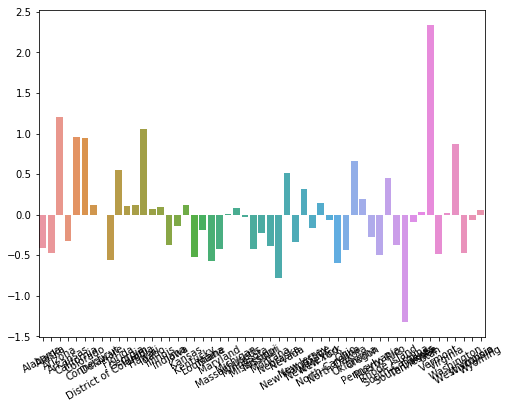

In [15]:

col = 'STATE FIPS CODE'
print("Column :",col)
s1 = df[df['label']==True][col].value_counts() 
s1 = s1 *100 / len(df[df['label']==True])
#s1 = s1.astype(int)
s2 = df[df['label']==False][col].value_counts() 
s2 = s2 *100 / len(df[df['label']==False])
#s2 = s2.astype(int)

vcountDF = pd.concat([s1, s2], axis=1)
vcountDF.columns = ['esmoke','smoke']
print(vcountDF)

fig, ax = plt.subplots(figsize=(8,6))
_=sns.barplot(vcountDF.index, vcountDF.esmoke-vcountDF.smoke,ax=ax).set_xticklabels(vcountDF.index,rotation=30)
#sns.barplot(vcountDF.index, vcountDF.smoke,ax=ax)

In [100]:
df['ads18_male'] = (df['RESPONDENTS SEX']=='Male') 
df['ads18_male'].value_counts()

False    238856
True     188670
Name: ads18_male, dtype: int64

In [101]:
df['ads18_healthCov'] = (df['HAVE ANY HEALTH CARE COVERAGE']=='Yes') 
df['ads18_healthCov'].value_counts()

True     392684
False     34842
Name: ads18_healthCov, dtype: int64

In [102]:
ageless40 = ['Imputed Age 35 to 39','Imputed Age 30 to 34','Imputed Age 25 to 29','Imputed Age 18 to 24' ]
df['ads18_older40'] = (df['IMPUTED AGE VALUE COLLAPSED ABOVE 80'].apply(lambda x: x not in ageless40) ) 
df['ads18_older40'].value_counts()

True     333170
False     94356
Name: ads18_older40, dtype: int64

In [103]:
ageless25 = ['Imputed Age 18 to 24' ]
df['ads18_age18_25'] = (df['IMPUTED AGE VALUE COLLAPSED ABOVE 80'].apply(lambda x: x in ageless25) ) 
df['ads18_age18_25'].value_counts()

False    402715
True      24811
Name: ads18_age18_25, dtype: int64

In [104]:
ageless25 = ['Imputed Age 25 to 29' ]
df['ads18_age25_30'] = (df['IMPUTED AGE VALUE COLLAPSED ABOVE 80'].apply(lambda x: x in ageless25) ) 
df['ads18_age25_30'].value_counts()

False    406416
True      21110
Name: ads18_age25_30, dtype: int64

In [105]:
df['ads18_seatbelt'] = (df['ALWAYS WEAR SEAT BELTS']=='Always Wear Seat Belt') 
df['ads18_seatbelt'].value_counts()

True     359320
False     68206
Name: ads18_seatbelt, dtype: int64

In [106]:
df['ads18_veteran'] = (df['ARE YOU A VETERAN']=='Yes') 
df['ads18_veteran'].value_counts()

False    372308
True      55218
Name: ads18_veteran, dtype: int64

In [107]:
df['ads18_affordDoc'] = (df['COULD NOT SEE DR. BECAUSE OF COST']=='No') 
df['ads18_affordDoc'].value_counts()

True     381472
False     46054
Name: ads18_affordDoc, dtype: int64

In [108]:
df['ads18_stroke'] = (df['EVER DIAGNOSED WITH A STROKE']=='Yes') 
df['ads18_stroke'].value_counts()

False    409473
True      18053
Name: ads18_stroke, dtype: int64

In [109]:
df['ads18_state'] = df['STATE FIPS CODE']
df['ads18_state'].value_counts()

Florida                 20843
Kansas                  20462
Minnesota               16318
Nebraska                14723
Arizona                 14584
Indiana                 13085
Washington              12663
Maryland                12638
Ohio                    11786
Texas                   11543
New York                11358
New Jersey              11134
South Carolina          10763
Michigan                10455
Connecticut              9937
Utah                     9919
Maine                    9257
Virginia                 9211
Colorado                 8844
California               8621
Kentucky                 8286
Hawaii                   7362
Missouri                 7328
Iowa                     7323
South Dakota             6800
North Dakota             6692
Massachusetts            6601
Alabama                  6408
Oklahoma                 6307
Pennsylvania             6298
New Mexico               6183
Vermont                  6127
Montana                  5757
Georgia   

In [110]:
adscols = [c for c in df.columns if 'ads18' in c]+['label']
len(adscols)

11

In [111]:
engineeredData2 = df[adscols]
print(len(engineeredData2))
#engineeredData.to_csv('engineeredData.csv')

427526


In [112]:
engineeredDataAll = pd.concat([engineeredData, engineeredData2], axis=1)
print(len(engineeredDataAll))
print(len(engineeredDataAll.columns))

427526
30


In [113]:
engineeredDataAll.to_csv('cleanDataSmoke.csv',index=False)

In [114]:
engineeredDataAll.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_healthCov,ads18_older40,ads18_age18_25,ads18_age25_30,ads18_seatbelt,ads18_veteran,ads18_affordDoc,ads18_stroke,ads18_state,label
0,False,True,True,False,False,False,True,7348.0,True,False,...,True,True,False,False,True,True,True,False,Alabama,No
1,False,True,False,False,False,False,True,9571.0,True,False,...,True,True,False,False,True,False,True,False,Alabama,No
2,False,False,True,False,False,False,True,8845.0,True,False,...,True,True,False,False,True,False,True,False,Alabama,No
3,False,True,True,False,False,False,True,7711.0,True,False,...,True,True,False,False,False,False,True,False,Alabama,No
4,True,False,False,False,True,False,True,6350.0,False,False,...,True,True,False,False,False,False,True,False,Alabama,No


In [3]:
import pandas as pd
list(pd.read_csv('cleanDataSmoke.csv').columns)

['ads18_frequentHealthIssue',
 'ads18_highBP',
 'ads18_highChl',
 'ads18_unknownChl',
 'ads18_asthma',
 'ads18_formerasthma',
 'ads18_white',
 'ads18_weight',
 'ads18_obese',
 'ads18_havechild',
 'ads18_edu',
 'ads18_income',
 'ads18_drinkdaily',
 'ads18_drinkbinge',
 'ads18_fruitIntake',
 'ads18_vegIntake',
 'ads18_potatoIntake',
 'ads18_exercise',
 'ads18_hivtest',
 'ads18_male',
 'ads18_healthCov',
 'ads18_older40',
 'ads18_age18_25',
 'ads18_age25_30',
 'ads18_seatbelt',
 'ads18_veteran',
 'ads18_affordDoc',
 'ads18_stroke',
 'ads18_state',
 'label']